In [15]:
import os, sys, pickle
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import sklearn
import scipy
import os

print(sys.version)
for i in [pd, np, mpl, sns, lgb, sklearn, scipy]:
    try:
        print(i.__name__, i.__version__)
    except:
        continue

3.12.3 (main, May  7 2024, 08:28:12) [GCC 9.4.0]
pandas 2.2.2
numpy 1.26.4
matplotlib 3.8.4
seaborn 0.13.2
lightgbm 4.3.0
sklearn 1.4.2
scipy 1.13.0


In [16]:
if not os.path.isdir('eval'):
    os.mkdir('eval')

if not os.path.isfile(os.path.join('data', 'train.csv')):
    !kaggle competitions download -c playground-series-s4e4
    !unzip playground-series-s4e4.zip -d data
    !rm playground-series-s4e4.zip
    !wget https://archive.ics.uci.edu/static/public/1/abalone.zip
    !unzip abalone.zip -d data
    !rm abalone.zip

df_train = pd.read_csv('data/train.csv', index_col='id')
df_test = pd.read_csv('data/test.csv', index_col='id')
# Assign the decreasing sequential numbers from -1
df_org = pd.read_csv('data/abalone.data', header=None).pipe(lambda x: x.set_index(-x.index - 1))
# Assign the columns of train set
df_org.columns = df_train.columns

 83%|███████████████████████████████▌      | 2.00M/2.41M [00:01<00:00, 2.35MB/s]
100%|██████████████████████████████████████| 2.41M/2.41M [00:01<00:00, 2.50MB/s]
Archive:  playground-series-s4e4.zip
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          
--2024-05-10 08:54:58--  https://archive.ics.uci.edu/static/public/1/abalone.zip
Connecting to 26.2.133.165:8080... connected.
Proxy request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘abalone.zip’

abalone.zip             [  <=>               ]  54.06K   194KB/s    in 0.3s    

2024-05-10 08:54:58 (194 KB/s) - ‘abalone.zip’ saved [55357]

Archive:  abalone.zip
  inflating: data/Index              
  inflating: data/abalone.data       
  inflating: data/abalone.names      


In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from scipy.stats import norm

def preprocess(df):
    df['Height'] = df['Height'].clip(0.004, 0.35)

preprocess(df_train)
df_train['target'] = np.log1p(df_train['Rings'])
preprocess(df_org)
df_org['target'] = np.log1p(df_org['Rings'])
preprocess(df_test)

X_pca = ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']
pca = make_pipeline(StandardScaler(), PCA())
pca.fit(pd.concat([df_train[X_pca], df_org[X_pca]], axis=0))

df_train[['pca1', 'pca2', 'pca3', 'pca4']] = pca.transform(df_train[X_pca])[:, :4]
df_org[['pca1', 'pca2', 'pca3', 'pca4']] = pca.transform(df_org[X_pca])[:, :4]
df_test[['pca1', 'pca2', 'pca3', 'pca4']] = pca.transform(df_test[X_pca])[:, :4]

df_train_org = pd.concat([df_train, df_org], axis=0).sort_values('pca1')
c = norm.ppf(0.999)
df_bound = df_train_org['target'].rolling(300, center=True, min_periods=1).agg(['mean', 'std']).assign(
    lb = lambda x: x['mean'] - c * x['std'],
    ub = lambda x: x['mean'] + c * x['std']
)

df_train_org['target_f'] = df_train_org['target'].where(df_train_org['target'] > df_bound['lb'], df_bound['lb'])
df_train_org['target_f'] = df_train_org['target_f'].where(df_train_org['target_f'] < df_bound['ub'], df_bound['ub'])
df_train_org['Rings_f'] = np.round(np.exp(df_train_org['target_f']) - 1).astype('int')

df_train['target_f'] = df_train_org['target_f']
df_org['target_f'] = df_train_org['target_f']

In [18]:
X_cont = ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']
X_cont = X_cont + ['pca1', 'pca2', 'pca3', 'pca4']
X_cat = ['Sex']
X_all = X_cont + X_cat
y = 'target'

## Common Routine

In [19]:
# 선택한 모델의 결과를 저장해두는 캐시 공간입니다.
selected_model = {}

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, PowerTransformer, MinMaxScaler, PolynomialFeatures, QuantileTransformer
from sklearn.ensemble import IsolationForest, VotingRegressor
from sklearn.model_selection import cross_validate, cross_val_predict, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import norm
import lightgbm as lgb
import xgboost as xgb

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
cv10 = StratifiedKFold(n_splits=10, random_state=123, shuffle=True)
ss = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=123)

def rmse(y, y_hat):
    return mean_squared_error(y, y_hat) ** 0.5

rmse_scorer = make_scorer(rmse, greater_is_better=False)
def get_eval_file(name):
    return os.path.join('eval', name + '.pkl')

def eval_model(model, name, cv=cv, exclude_idx = None, include_org = True):
    """
    모델을 평가합니다.
    Parameters:
        model: 모델
    """
    file_name = get_eval_file(name)
    if not os.path.isfile(file_name):
        scores = {
            'train_score': [],
            'test_score': []
        }
        prds = list()
        y_min, y_max = df_train[y].min(), df_train[y].max()
        for fold, (train_idx, test_idx) in enumerate(cv.split(df_train[X_all], df_train['Rings'])):
            df_cv_train, df_valid = df_train.iloc[train_idx], df_train.iloc[test_idx]
            if include_org:
                df_cv_train_ = pd.concat([df_cv_train, df_org], axis=0)
            else:
                df_cv_train_ = df_cv_train
            if exclude_idx is not None:
                df_cv_train_ = df_cv_train_.loc[~df_cv_train_.index.isin(exclude_idx)]
            model.fit(df_cv_train_[X_all], df_cv_train_['target_f'])
            scores['train_score'].append(rmse(df_cv_train[y], model.predict(df_cv_train[X_all])))
            prd_val = np.clip(model.predict(df_valid[X_all]), y_min, y_max)
            scores['test_score'].append(rmse(df_valid[y], prd_val))
            prds.append(pd.Series(prd_val, index=df_valid.index, name=name))
        scores['prd_cv'] = pd.concat(prds, axis=0)
        return scores
    else:
        return None
    
def select_model(model, name, scores, exclude_idx=None, include_org = True):
    file_name = get_eval_file(name)
    y_min, y_max = df_train[y].min(), df_train[y].max()
    if not os.path.isfile(file_name):
        if model is None or scores is None:
            raise Exception("Invalid parameters")
        result = scores.copy()
        if include_org:
            df_train_ = pd.concat([df_train, df_org], axis=0)
        else:
            df_train_ = df_train
        
        if exclude_idx is not None:
            df_train_ = df_train_.loc[~df_train_.index.isin(exclude_idx)]
        model.fit(df_train_[X_all], df_train_['target_f'])
        result['final_train_score'] = rmse(df_train['target'], model.predict(df_train[X_all]))
        result['prd_test'] = np.clip(model.predict(df_test[X_all]), y_min, y_max)
        with open(file_name, 'wb') as f:
            pickle.dump(result, f)
        selected_model[name] = result
    else:
        if name in selected_model:
            result = selected_model[name]
        with open(file_name, 'rb') as f:
            result = pickle.load(f)
            selected_model[name] = result
    return result

def stack_model(model, model_names, exclude_idx=None, cv=cv):
    df_stack = pd.concat([selected_model[i]['prd_cv'] for i in model_names] + [df_train[['Rings', y]]], axis=1).sort_index()
    train_score, test_score = list(), list()
    prds = list()
    for train_idx, test_idx in cv.split(df_stack, df_stack['Rings']):
        df_cv_train = df_stack.iloc[train_idx]
        df_valid = df_stack.iloc[test_idx]
        if exclude_idx is not None:
            df_cv_train = df_cv_train.loc[~df_cv_train.index.isin(exclude_idx)]
        model.fit(df_cv_train[model_names], df_cv_train[y])
        prd = model.predict(df_valid[model_names])
        test_score.append(rmse(df_valid[y], prd))
        prds.append(pd.Series(prd, index=df_valid.index))
        train_score.append(rmse(df_cv_train[y], model.predict(df_cv_train[model_names])))
    return {'train_score': train_score, 'test_score': test_score, 'prds': pd.concat(prds, axis=0).sort_index()}

def select_stack_model(name, model, model_names):
    X_stk = pd.concat([selected_model[i]['prd_cv'] for i in model_names], axis=1).sort_index().values
    model.fit(X_stk, df_train[y].sort_index())
    print(rmse(df_train[y], model.predict(X_stk)))
    pd.DataFrame(
        {'Rings': np.exp(model.predict(np.vstack([selected_model[i]['prd_test'] for i in model_names]).T)) - 1}, 
        index = df_test.index
    ).to_csv(os.path.join('eval', name + '.csv'))

def print_scores(scores):
    print(
        "Test: ", np.mean(scores['test_score']), np.std(scores['test_score']), 
        " Train: ", np.mean(scores['train_score']), np.std(scores['train_score']),
        " Final Train:", scores.get('final_train_score', '?')
    )
    
def plot_cv_result(name):
    prd_cv = selected_model[name]['prd_cv']
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    sns.scatterplot(x = df_train[y], y = (prd_cv - df_train[y]), ax=axes[0])
    sns.lineplot(x = df_train[y], y = (prd_cv - df_train[y]) ** 2, hue=df_train['Sex'], ax=axes[1])
    sns.histplot(x=df_train[y], ax=axes[1].twinx(), hue=df_train['Sex'], multiple='stack')
    diff = selected_model[name]['prd_cv'] - df_train[y]
    sns.scatterplot(df_train, x = 'pca1', y = 'pca2', s=diff.abs() ** 2, alpha=1, ax=axes[2])
    plt.xlabel('pca0')
    plt.ylabel('pca1')
    plt.tight_layout()
    plt.show()

## Noise Detection

In [21]:
# 모든 데터셋을 사용하여 가장 좋은 분류 성능을 단일 모델입니다.
reg_ol = make_pipeline(
    ColumnTransformer([
        ('pt', 'passthrough',['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']),
        ('ohe', OneHotEncoder(), X_cat)
    ]),
    lgb.LGBMRegressor(verbose=-1, random_state=123, num_leaves=63, n_estimators=1500, learning_rate=0.02, 
                      colsample_bytree=0.75, subsample=0.9, subsample_freq=1, 
                      reg_lambda=0.005)
)

scores = eval_model(reg_ol, 'ol')
scores = select_model(reg_ol, 'ol', scores)
s_err = scores['prd_cv'] - df_train['target']
# 교차 검증의 오차가 상위 0.82이상인 데이터는 err=True
# 0.18 이하인 데이터는 err=False하여 
# err 클래스를 구분해보는 데이터셋을 만듭니다.
df_err = pd.concat([
    df_train.loc[s_err > s_err.quantile(0.82)].assign(
        err = True
    ),
    df_train.loc[s_err < s_err.quantile(0.18)].assign(
        err = False
    )
])
print_scores(select_model(reg_ol, 'ol', scores))
err_prd = cross_val_predict(
    make_pipeline(ColumnTransformer([
        ('pt', 'passthrough',['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']),
        ('ohe', OneHotEncoder(), X_cat)
    ]),
    lgb.LGBMClassifier(verbose=-1, random_state=123, num_leaves=63, n_estimators=2000, learning_rate=0.1)), df_err[X_all], df_err['err'], 
    cv = cv10
)
# err=True/False를 구분하지 못하는 경우는 Regression 모델을 노이즈에 해당하는 데이터셋으로 간주합니다.
exclude_idx = df_err.loc[(err_prd != df_err['err'])].index.tolist()
(err_prd == df_err['err']).mean(), len(exclude_idx)

Test:  0.1478897007534629 0.0006517437137629421  Train:  0.1323164736162684 0.00016316324181627815  Final Train: 0.13433088146757452


(0.4932867390104837, 16530)

## Linear Regression

In [22]:
reg_lr = make_pipeline(
    ColumnTransformer([
        ('std', RobustScaler(), ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']),
        ('ohe', OneHotEncoder(drop='first'), X_cat)
    ]),
    LinearRegression()
)
scores = eval_model(reg_lr, 'lr', exclude_idx=None)
if scores is not None:
    print_scores(scores)

Test:  0.1639678099937038 0.000984709898832639  Train:  0.16395820010634418 0.0002467251527800074  Final Train: ?


In [23]:
print_scores(select_model(reg_lr, 'lr', scores, exclude_idx=None))

Test:  0.1639678099937038 0.000984709898832639  Train:  0.16395820010634418 0.0002467251527800074  Final Train: 0.16395673752958143


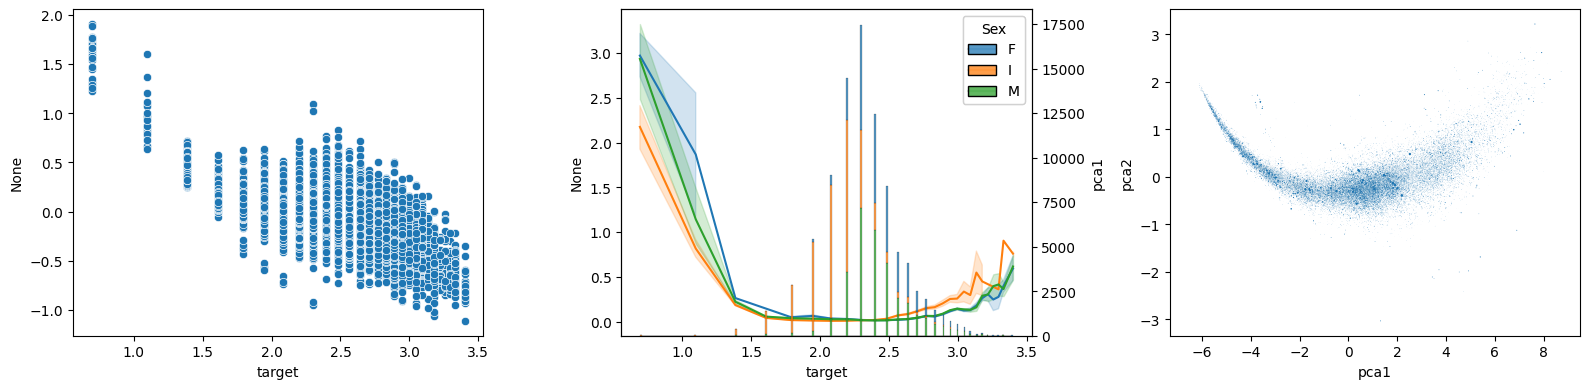

In [24]:
plot_cv_result('lr')

In [25]:
reg_lr2 = make_pipeline(
    ColumnTransformer([
        ('std', make_pipeline(RobustScaler(), PolynomialFeatures((2, 3), include_bias=False)), 
            ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']),
        ('pow', RobustScaler(), 
            ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']),
        ('ohe', OneHotEncoder(drop='first'), X_cat)
    ]),
    LinearRegression()
)
scores = eval_model(reg_lr2, 'lr2', exclude_idx=None)
if scores is not None:
    print_scores(scores)

Test:  0.15339062465915285 0.0009041580610874928  Train:  0.15300609344564048 0.00022951910611781053  Final Train: ?


In [26]:
print_scores(select_model(reg_lr2, 'lr2', scores, exclude_idx=None))

Test:  0.15339062465915285 0.0009041580610874928  Train:  0.15300609344564048 0.00022951910611781053  Final Train: 0.15302661919290325


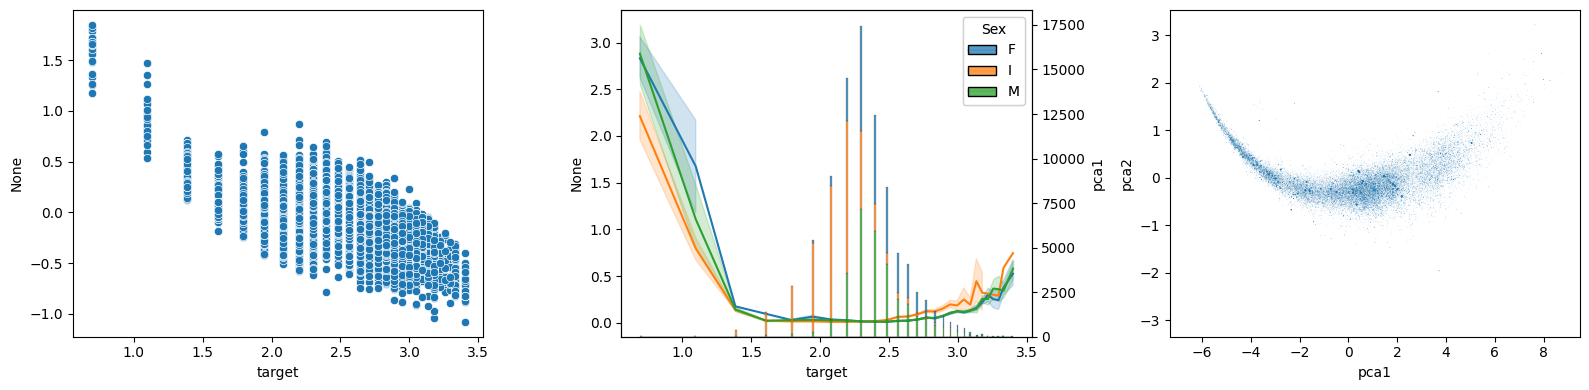

In [27]:
plot_cv_result('lr2')

In [28]:
df_train.loc[
    (selected_model['lr2']['prd_cv'] - df_train[y]).sort_values().head(10).index.tolist() + 
    (selected_model['lr2']['prd_cv'] - df_train[y]).sort_values().tail(10).index.tolist()
]

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,target,pca1,pca2,pca3,pca4,target_f
id,,,,,,,,,,,,,,,
43655,F,0.365,0.275,0.165,0.2875,0.1000,0.0755,0.0750,29,3.401197,-2.343516,-0.672095,1.177109,1.188792,2.639969
12665,M,0.340,0.265,0.095,0.2075,0.0810,0.0565,0.0700,23,3.178054,-3.339469,0.136093,0.274541,0.130738,2.575399
65512,I,0.380,0.325,0.110,0.3695,0.1590,0.0625,0.1150,23,3.178054,-2.400586,-0.085819,0.194694,0.087483,2.615624
80512,I,0.385,0.285,0.100,0.2265,0.0705,0.0600,0.1000,22,3.135494,-2.972271,-0.130135,0.255576,-0.064021,2.617416
12355,I,0.340,0.285,0.100,0.2000,0.0745,0.0365,0.0800,20,3.044522,-3.276879,-0.090187,0.319311,0.078352,2.561198
28304,I,0.370,0.275,0.100,0.2500,0.0960,0.0665,0.0850,20,3.044522,-3.011678,0.043535,0.245743,0.106065,2.653068
21845,M,0.580,0.455,0.170,0.9555,0.4300,0.1960,0.2575,26,3.295837,1.231594,-0.423409,0.083501,0.356243,3.122231
63912,I,0.350,0.260,0.090,0.1925,0.0745,0.0435,0.0655,18,2.944439,-3.462141,0.106614,0.172296,0.045254,2.531749
61714,I,0.365,0.270,0.085,0.2145,0.0855,0.0485,0.0700,18,2.944439,-3.354454,0.135564,0.011845,-0.073099,2.624751


In [29]:
selected_model['lr2']['prd_cv'].agg(['min', 'max'])

min    1.428052
max    3.233285
Name: lr2, dtype: float64

## LGB

### LGB 1

In [30]:
reg_lgb = make_pipeline(
    ColumnTransformer([
        ('pt', 'passthrough',['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']),
        ('ohe', OneHotEncoder(), X_cat)
    ]),
    lgb.LGBMRegressor(verbose=-1, random_state=123, max_depth=4, n_estimators=3000, learning_rate=0.09, colsample_bytree=0.75, subsample=0.9, subsample_freq=1, 
                      reg_lambda=0.0007)
)
scores = eval_model(reg_lgb, 'lgb', exclude_idx=exclude_idx)
if scores is not None:
    print_scores(scores)

Test:  0.14599272962950308 0.0007956356770134977  Train:  0.13722690071947652 0.00025693496609882773  Final Train: ?


In [31]:
print_scores(select_model(reg_lgb, 'lgb', scores, exclude_idx=exclude_idx))

Test:  0.14599272962950308 0.0007956356770134977  Train:  0.13722690071947652 0.00025693496609882773  Final Train: 0.13790827832496622


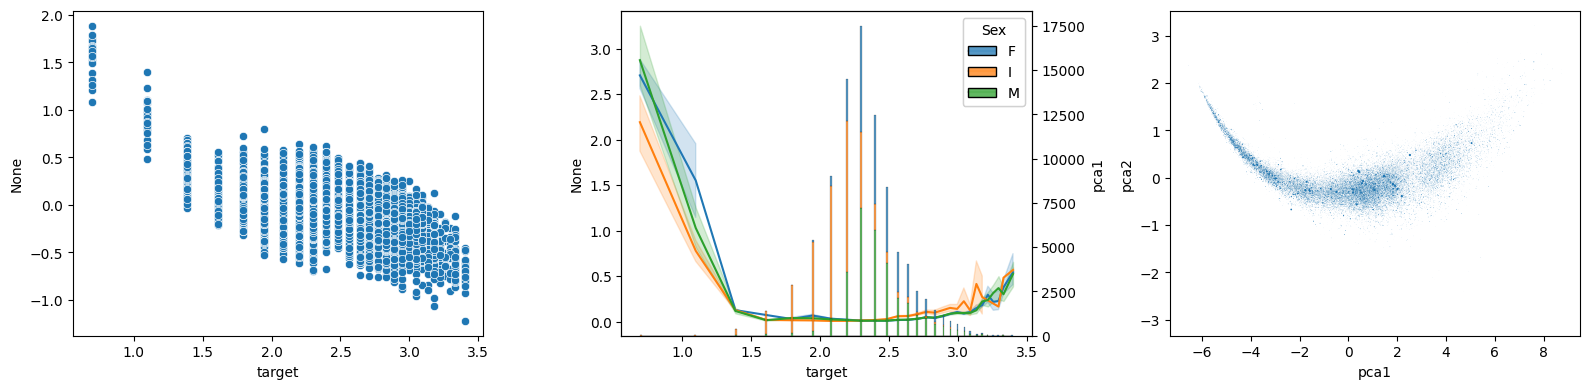

In [32]:
plot_cv_result('lgb')

### LGB 2

In [33]:
reg_lgb2 = make_pipeline(
    ColumnTransformer([
        ('pt', 'passthrough',['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']),
        ('ohe', OneHotEncoder(), X_cat)
    ]),
    lgb.LGBMRegressor(verbose=-1, random_state=123, num_leaves=15, n_estimators=3000, learning_rate=0.08, colsample_bytree=0.75, subsample=0.9, subsample_freq=1, 
                      reg_lambda=0.0001)
)
scores = eval_model(reg_lgb2, 'lgb2', exclude_idx=exclude_idx)
if scores is not None:
    print_scores(scores)

Test:  0.14573884958912284 0.0007008810397647882  Train:  0.13409050515936521 0.0002774212880633144  Final Train: ?


In [34]:
print_scores(select_model(reg_lgb2, 'lgb2', scores, exclude_idx=exclude_idx))

Test:  0.14573884958912284 0.0007008810397647882  Train:  0.13409050515936521 0.0002774212880633144  Final Train: 0.13509962188123842


### LGB 3

In [35]:
reg_lgb3 = make_pipeline(
    ColumnTransformer([
        ('pt', 'passthrough',['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']),
        ('ohe', OneHotEncoder(), X_cat)
    ]),
    lgb.LGBMRegressor(verbose=-1, random_state=123, num_leaves=31, n_estimators=3000, learning_rate=0.05, colsample_bytree=0.75, subsample=0.9, subsample_freq=1, 
                      reg_lambda=0.0001)
)
scores = eval_model(reg_lgb3, 'lgb3', exclude_idx=exclude_idx)
if scores is not None:
    print_scores(scores)

Test:  0.14531077699237488 0.0007942463807513604  Train:  0.13066081314171205 0.00021090242563796686  Final Train: ?


In [36]:
print_scores(select_model(reg_lgb3, 'lgb3', scores, exclude_idx=exclude_idx))

Test:  0.14531077699237488 0.0007942463807513604  Train:  0.13066081314171205 0.00021090242563796686  Final Train: 0.1319286556746623


### LGB 4

In [37]:
reg_lgb4 = make_pipeline(
    ColumnTransformer([
        ('pt', 'passthrough',['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']),
        ('ohe', OneHotEncoder(), X_cat)
    ]),
    lgb.LGBMRegressor(verbose=-1, random_state=123, num_leaves=63, n_estimators=2500, learning_rate=0.03, colsample_bytree=0.75, subsample=0.9, subsample_freq=1, 
                      reg_lambda=0.001)
)

scores = eval_model(reg_lgb4, 'lgb4', exclude_idx=exclude_idx)
if scores is not None:
    print_scores(scores)

Test:  0.14524526251440353 0.0008278889190278586  Train:  0.1297292778053668 0.00023844148568647884  Final Train: ?


In [38]:
print_scores(select_model(reg_lgb4, 'lgb4', scores, exclude_idx=exclude_idx))

Test:  0.14524526251440353 0.0008278889190278586  Train:  0.1297292778053668 0.00023844148568647884  Final Train: 0.13111380032853934


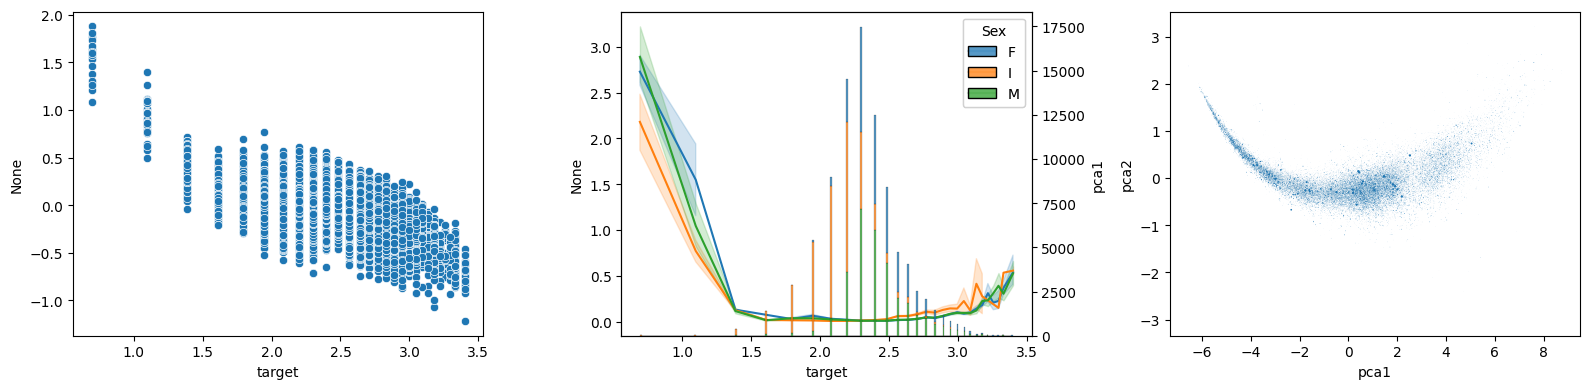

In [39]:
plot_cv_result('lgb4')

### LGB 5

In [40]:
reg_lgb5 = make_pipeline(
    ColumnTransformer([
        ('pt', 'passthrough',['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']),
        ('ohe', OneHotEncoder(), X_cat)
    ]),
    lgb.LGBMRegressor(verbose=-1, random_state=123, num_leaves=127, n_estimators=2000, learning_rate=0.02, colsample_bytree=0.75, subsample=0.9, subsample_freq=1, 
                      reg_lambda=0.0005)
)
scores = eval_model(reg_lgb5, 'lgb5', exclude_idx=exclude_idx)
if scores is not None:
    print_scores(scores)

Test:  0.1452551021944361 0.000843571288436687  Train:  0.1286282414879989 0.00023920378736738373  Final Train: ?


In [41]:
print_scores(select_model(reg_lgb5, 'lgb5', scores, exclude_idx=exclude_idx))

Test:  0.1452551021944361 0.000843571288436687  Train:  0.1286282414879989 0.00023920378736738373  Final Train: 0.1300603921786031


### LGB 6

In [42]:
reg_lgb6 = make_pipeline(
    ColumnTransformer([
        ('pt', 'passthrough',['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']),
        ('ohe', OneHotEncoder(), X_cat)
    ]),
    lgb.LGBMRegressor(verbose=-1, random_state=123, max_depth=5, n_estimators=3000, learning_rate=0.07, colsample_bytree=0.75, subsample=0.9, subsample_freq=1, 
                      reg_lambda=0.001)
)
scores = eval_model(reg_lgb6, 'lgb6', exclude_idx=exclude_idx)
if scores is not None:
    print_scores(scores)

Test:  0.14568491815402546 0.0008390521243669237  Train:  0.13417898833132771 0.00028043108324493204  Final Train: ?


In [43]:
print_scores(select_model(reg_lgb6, 'lgb6', scores, exclude_idx=exclude_idx))

Test:  0.14568491815402546 0.0008390521243669237  Train:  0.13417898833132771 0.00028043108324493204  Final Train: 0.13500074895050684


### LGB 7

In [44]:
reg_lgb7 = make_pipeline(
    ColumnTransformer([
        ('pt', 'passthrough',['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']),
        ('ohe', OneHotEncoder(), X_cat)
    ]),
    lgb.LGBMRegressor(verbose=-1, random_state=123, max_depth=6, n_estimators=3000, learning_rate=0.06, colsample_bytree=0.75, subsample=0.9, subsample_freq=1, 
                      reg_lambda=0.0001)
)
scores = eval_model(reg_lgb7, 'lgb7', exclude_idx=exclude_idx)
if scores is not None:
    print_scores(scores)

Test:  0.14554850263656255 0.0009146498682762835  Train:  0.1322580384722058 0.00022870423448298363  Final Train: ?


In [45]:
print_scores(select_model(reg_lgb7, 'lgb7', scores, exclude_idx=exclude_idx))

Test:  0.14554850263656255 0.0009146498682762835  Train:  0.1322580384722058 0.00022870423448298363  Final Train: 0.13327070153896486


## NN

In [46]:
import sgnn

2024-05-10 08:59:32.867942: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-10 08:59:33.527670: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [47]:
reg_nn = make_pipeline(
    ColumnTransformer([
        ('std', RobustScaler(quantile_range=(0.01, 0.95)), 
             ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']),
        ('ohe', OneHotEncoder(drop='first'), X_cat)
    ]),
    sgnn.NNRegressor([
            {'unit': 128, 'activation': 'relu', 'batch_norm': True},
            {'unit': 128, 'activation': 'relu', 'batch_norm': True},
            {'unit': 64, 'activation': 'relu', 'batch_norm': True},
            {'unit': 32, 'activation': 'relu', 'batch_norm': True},
       ],
       batch_size=512,
       shuffle_size=2048000,
       verbose=0,
       validation_fraction=0.1,
       learning_rate=0.01,
       reduce_lr_on_plateau={'factor': 0.1, 'patience': 5},
       early_stopping={'patience': 10},
       epochs=150
   )
)
scores = eval_model(reg_nn, 'nn', exclude_idx=None)
if scores is not None:
    print_scores(scores)

2024-05-10 08:59:34.016286: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-10 08:59:34.039248: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-10 08:59:34.039409: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Test:  0.15118054885782722 0.0008983710606419564  Train:  0.15025368252053675 0.00018734033276056363  Final Train: ?


In [48]:
print_scores(select_model(reg_nn, 'nn', scores, exclude_idx=None))

Test:  0.15118054885782722 0.0008983710606419564  Train:  0.15025368252053675 0.00018734033276056363  Final Train: 0.15009632006824675


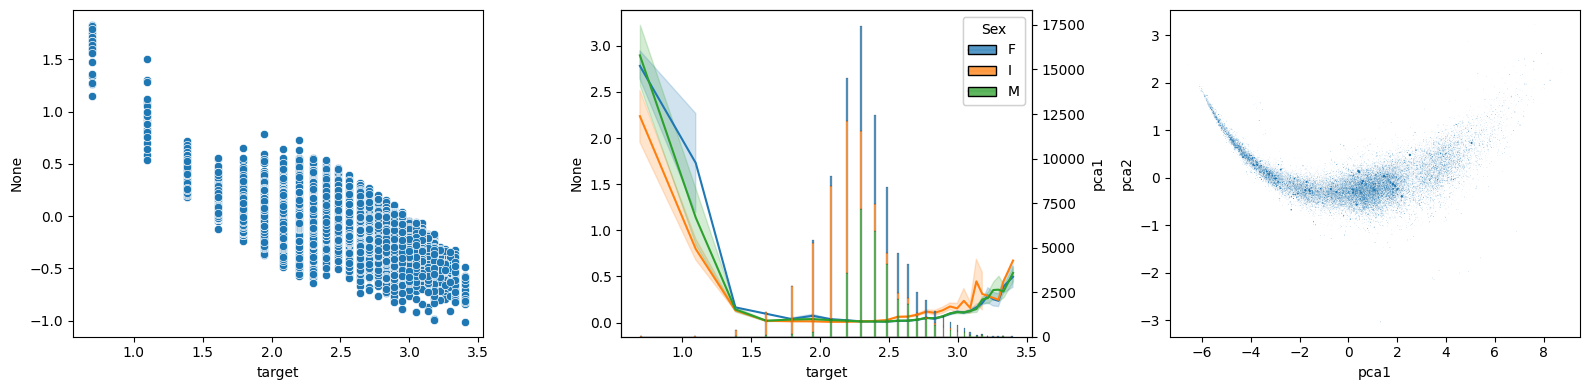

In [49]:
plot_cv_result('nn')

## XGB

### XGB1

In [50]:
reg_xgb = make_pipeline(
    ColumnTransformer([
        ('pt', 'passthrough',['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']),
        ('ohe', OneHotEncoder(), X_cat)
    ]),
    xgb.XGBRegressor(random_state=123, max_depth=5, n_estimators=3000, learning_rate=0.04, colsample_bytree=0.75, subsample=0.95)
)
scores = eval_model(reg_xgb, 'xgb', exclude_idx=exclude_idx)
if scores is not None:
    print_scores(scores)

Test:  0.14642232016130502 0.000809487054773252  Train:  0.1361938532867202 0.000331536768435155  Final Train: ?


In [51]:
print_scores(select_model(reg_xgb, 'xgb', scores, exclude_idx=exclude_idx))

Test:  0.14642232016130502 0.000809487054773252  Train:  0.1361938532867202 0.000331536768435155  Final Train: 0.13742363341758296


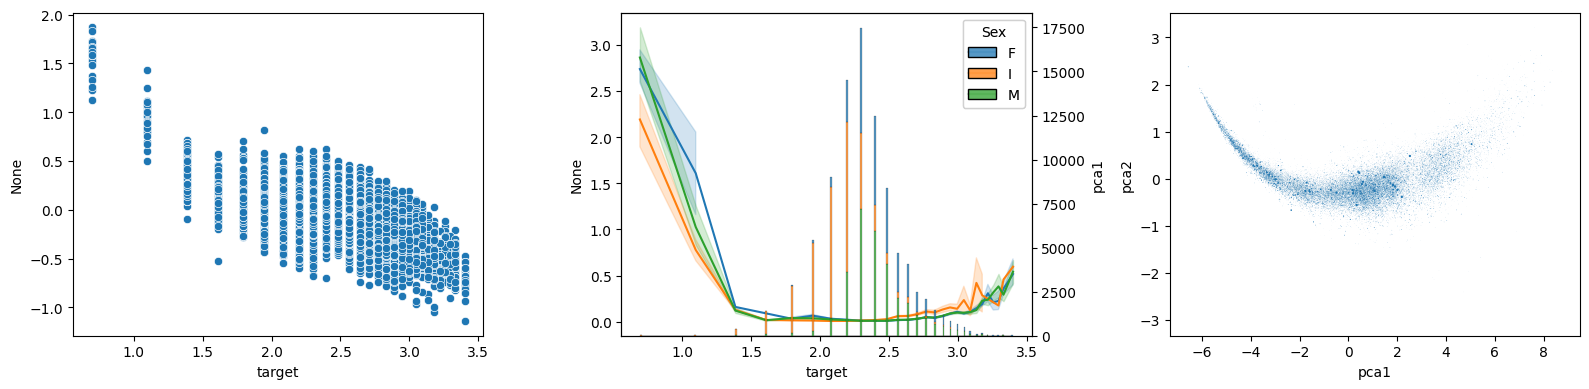

In [52]:
plot_cv_result('xgb')

### XGB 2

In [79]:
reg_xgb2 = make_pipeline(
    ColumnTransformer([
        ('pt', 'passthrough',['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']),
        ('ohe', OneHotEncoder(), X_cat)
    ]),
    xgb.XGBRegressor(random_state=123, max_depth=6, n_estimators=3500, learning_rate=0.03, colsample_bytree=0.75, subsample=0.8)
)
scores = eval_model(reg_xgb2, 'xgb2', exclude_idx=exclude_idx)
if scores is not None:
    print_scores(scores)

Test:  0.1462415862715359 0.0007694226844951469  Train:  0.09483292366227931 0.0011024438753348984


In [80]:
print_scores(select_model(reg_xgb2, 'xgb2', scores, exclude_idx=exclude_idx))

Test:  0.1462415862715359 0.0007694226844951469  Train:  0.09483292366227931 0.0011024438753348984


### XGB 3

In [83]:
reg_xgb3 = make_pipeline(
    ColumnTransformer([
        ('pt', 'passthrough',['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']),
        ('ohe', OneHotEncoder(), X_cat)
    ]),
    xgb.XGBRegressor(random_state=123, max_depth=7, n_estimators=3000, learning_rate=0.02, colsample_bytree=0.6, subsample=0.8)
)
scores = eval_model(reg_xgb3, 'xgb3', exclude_idx=exclude_idx)
if scores is not None:
    print_scores(scores)

Test:  0.14607156895535053 0.0007344605336394116  Train:  0.09498676622004955 0.0007936934463987161


In [84]:
print_scores(select_model(reg_xgb3, 'xgb3', scores, exclude_idx=exclude_idx))

Test:  0.14607156895535053 0.0007344605336394116  Train:  0.09498676622004955 0.0007936934463987161


### XGB 4

In [91]:
reg_xgb4 = make_pipeline(
    ColumnTransformer([
        ('pt', 'passthrough',['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']),
        ('ohe', OneHotEncoder(), X_cat)
    ]),
    xgb.XGBRegressor(random_state=123, grow_policy= 'lossguide', max_leaves=31, n_estimators=2500, learning_rate=0.05, colsample_bytree=0.6, subsample=0.8)
)
scores = eval_model(reg_xgb4, 'xgb4', exclude_idx=exclude_idx)
if scores is not None:
    print_scores(scores)

Test:  0.14642663278828308 0.0007488231000258941  Train:  0.09943413404853549 0.0004505226419163373


In [92]:
print_scores(select_model(reg_xgb4, 'xgb4', scores, exclude_idx=exclude_idx))

Test:  0.14642663278828308 0.0007488231000258941  Train:  0.09943413404853549 0.0004505226419163373


### XGB 5

In [95]:
reg_xgb5 = make_pipeline(
    ColumnTransformer([
        ('pt', 'passthrough',['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']),
        ('ohe', OneHotEncoder(), X_cat)
    ]),
    xgb.XGBRegressor(random_state=123, grow_policy= 'lossguide', max_leaves=63, n_estimators=3000, learning_rate=0.03, colsample_bytree=0.75, subsample=0.9)
)
scores = eval_model(reg_xgb5, 'xgb5', exclude_idx=exclude_idx)
if scores is not None:
    print_scores(scores)

Test:  0.14619731414169773 0.0007528600198239447  Train:  0.09706898586247763 0.0006872210500780457


In [96]:
print_scores(select_model(reg_xgb5, 'xgb5', scores, exclude_idx=exclude_idx))

Test:  0.14619731414169773 0.0007528600198239447  Train:  0.09706898586247763 0.0006872210500780457


### XGB7

In [54]:
reg_xgb7 = make_pipeline(
    ColumnTransformer([
        ('pt', 'passthrough',['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']),
        ('ohe', OneHotEncoder(), X_cat)
    ]),
    xgb.XGBRegressor(random_state=123, max_depth=8, n_estimators=2700, learning_rate=0.02, colsample_bytree=0.75, subsample=0.9)
)
scores = eval_model(reg_xgb7, 'xgb7', exclude_idx=exclude_idx)
if scores is not None:
    print_scores(scores)

Test:  0.14604476744410133 0.000767567733619739  Train:  0.12644789108141452 0.00038971306939894436  Final Train: ?


In [55]:
print_scores(select_model(reg_xgb7, 'xgb7', scores, exclude_idx=exclude_idx))

Test:  0.14604476744410133 0.000767567733619739  Train:  0.12644789108141452 0.00038971306939894436  Final Train: 0.12836817064241687


# CatBoost

In [56]:
import catboost as cb

### CB 1

In [57]:
cb_params = {
    'grow_policy': 'SymmetricTree', 
    'n_estimators': 3000, 
    'learning_rate': 0.1, 
    'max_depth': 7, 
    'colsample_bylevel': 0.75,
    'boost_from_average': True, 'loss_function': 'RMSE', 'random_strength': 0, 'verbose': 0}

reg_cb = make_pipeline(
    ColumnTransformer([
        ('pt', 'passthrough',['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']),
        ('ohe', OneHotEncoder(), X_cat)
    ]),
    cb.CatBoostRegressor(**cb_params)
)
scores = eval_model(reg_cb, 'cb', exclude_idx=exclude_idx)
if scores is not None:
    print_scores(scores)

Test:  0.14603208228505432 0.0008705472588386258  Train:  0.13230271200694724 0.00023216039645624004  Final Train: ?


In [58]:
print_scores(select_model(reg_cb, 'cb', scores, exclude_idx=exclude_idx))

Test:  0.14603208228505432 0.0008705472588386258  Train:  0.13230271200694724 0.00023216039645624004  Final Train: 0.13366805996417952


### CB 2

In [59]:
cb_params = {
    'grow_policy': 'SymmetricTree', 
    'n_estimators': 3000, 
    'learning_rate': 0.1, 
    'max_depth': 6, 
    'colsample_bylevel': 0.9, 
    'boost_from_average': True, 'loss_function': 'RMSE', 'random_strength': 0, 'verbose': 0}

reg_cb2 = make_pipeline(
    ColumnTransformer([
        ('pt', 'passthrough',['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']),
        ('ohe', OneHotEncoder(), X_cat)
    ]),
    cb.CatBoostRegressor(**cb_params)
)
scores = eval_model(reg_cb2, 'cb2', exclude_idx=exclude_idx)
if scores is not None:
    print_scores(scores)

Test:  0.146022545790382 0.0007758581451781304  Train:  0.1354959568947694 0.0002731512338687236  Final Train: ?


In [60]:
print_scores(select_model(reg_cb2, 'cb2', scores, exclude_idx=exclude_idx))

Test:  0.146022545790382 0.0007758581451781304  Train:  0.1354959568947694 0.0002731512338687236  Final Train: 0.1365982837045925


### CB 3

In [61]:
cb_params = {
    'grow_policy': 'SymmetricTree', 
    'n_estimators': 3500, 
    'learning_rate': 0.12, 
    'max_depth': 5, 
    'colsample_bylevel': 0.9, 
    'boost_from_average': True, 'loss_function': 'RMSE', 'random_strength': 0, 'verbose': 0}

reg_cb3 = make_pipeline(
    ColumnTransformer([
        ('pt', 'passthrough',['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']),
        ('ohe', OneHotEncoder(), X_cat)
    ]),
    cb.CatBoostRegressor(**cb_params)
)
scores = eval_model(reg_cb3, 'cb3', exclude_idx=exclude_idx)
if scores is not None:
    print_scores(scores)

Test:  0.1462748128900198 0.0008194007089861993  Train:  0.13672706583316832 0.0002273079659248867  Final Train: ?


In [62]:
print_scores(select_model(reg_cb3, 'cb3', scores, exclude_idx=exclude_idx))

Test:  0.1462748128900198 0.0008194007089861993  Train:  0.13672706583316832 0.0002273079659248867  Final Train: 0.13757592997424517


# KNN

## KNN 1

In [63]:
reg_knn2 = make_pipeline(
    ColumnTransformer([
        ('std', RobustScaler(quantile_range=(0.01, 0.99)), ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']),
        ('ohe', OneHotEncoder(), X_cat[:-1])
    ]),
    KNeighborsRegressor(n_neighbors=40)
)
scores2 = eval_model(reg_knn2, 'knn', exclude_idx=None)
if scores2 is not None:
    print_scores(scores2)

Test:  0.1550480713459051 0.001220597306577527  Train:  0.15141183813626674 0.00029273458344944886  Final Train: ?


In [64]:
print_scores(select_model(reg_knn2, 'knn', scores2, exclude_idx=None))

Test:  0.1550480713459051 0.001220597306577527  Train:  0.15141183813626674 0.00029273458344944886  Final Train: 0.1512564753393524


## KNN 2

In [65]:
reg_knn =  make_pipeline(
    ColumnTransformer([
        ('std_pca', make_pipeline(PCA(n_components=4), MinMaxScaler()), 
         ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']),
        ('ohe', OneHotEncoder(), X_cat)
    ]), KNeighborsRegressor(n_neighbors=60)
)
scores = eval_model(reg_knn, 'knn2', exclude_idx=None)
if scores is not None:
    print_scores(scores)

Test:  0.15353060985018382 0.0007764497462042356  Train:  0.15110975717073727 0.0002082973519187243  Final Train: ?


In [66]:
print_scores(select_model(reg_knn, 'knn2', scores, exclude_idx=None))

Test:  0.15353060985018382 0.0007764497462042356  Train:  0.15110975717073727 0.0002082973519187243  Final Train: 0.15088644614037744


## 1

In [368]:
result = stack_model(LinearRegression(), ['lr', 'lgb', 'lgb2', 'lgb3', 'lgb4', 'lgb5', 'lgb6', 'lgb7', 'nn', 'xgb', 'xgb2', 'xgb3', 'xgb4', 'xgb5'])
print_scores(result)

Test:  0.14742758751918 0.0006389990112638853  Train:  0.14737715684986666 0.0001608113191325268


In [447]:
select_stack_model('1', LinearRegression(), ['lr', 'lgb', 'lgb2', 'lgb3', 'lgb4', 'lgb5', 'lgb6', 'lgb7', 'nn', 'xgb', 'xgb2', 'xgb3', 'xgb4', 'xgb5'])

In [398]:
# !kaggle competitions submit -c playground-series-s4e4 -f eval/1.csv -m "2"

100%|███████████████████████████████████████| 1.45M/1.45M [00:02<00:00, 523kB/s]
Successfully submitted to Regression with an Abalone Dataset

## 3

In [338]:
result = stack_model(LinearRegression(), ['lr', 'lgb', 'lgb2', 'lgb3', 'lgb4', 'lgb5', 'lgb6', 'lgb7', 'nn', 'xgb', 'xgb2', 'xgb3', 'xgb4', 'xgb5', 'knn'])
print_scores(result)

Test:  0.1480727748514459 0.0006598851694882501  Train:  0.14801256098865406 0.00016477947898673208


In [339]:
select_stack_model('3', LinearRegression(), ['lr', 'lgb', 'lgb2', 'lgb3', 'lgb4', 'lgb5', 'lgb6', 'lgb7', 'nn', 'xgb', 'xgb2', 'xgb3', 'xgb4', 'xgb5', 'knn'])

In [ ]:
# !kaggle competitions submit -c playground-series-s4e4 -f eval/3.csv -m "3"

## 4

In [347]:
result = stack_model(LinearRegression(), ['lr2', 'lgb', 'lgb2', 'lgb3', 'lgb4', 'lgb5', 'lgb6', 'lgb7', 'lgb8', 'nn', 'xgb', 'xgb2', 'xgb3', 'xgb4', 'xgb5', 'knn'])
print_scores(result)

Test:  0.14800952192265399 0.0006838919050611077  Train:  0.14794548536401705 0.0001691744057557412


In [448]:
select_stack_model('4', LinearRegression(), ['lr2', 'lgb', 'lgb2', 'lgb3', 'lgb4', 'lgb5', 'lgb6', 'lgb7', 'lgb8', 'nn', 'xgb', 'xgb2', 'xgb3', 'xgb4', 'xgb5', 'knn'])

In [449]:
# !kaggle competitions submit -c playground-series-s4e4 -f eval/4.csv -m "4"

100%|███████████████████████████████████████| 1.45M/1.45M [00:05<00:00, 276kB/s]
Successfully submitted to Regression with an Abalone Dataset

## 5

In [180]:
sel_prd = ['lr2', 'lgb', 'lgb2', 'lgb3', 'lgb4', 'lgb5', 'lgb6', 'lgb7', 'lgb8', 'nn', 
           'xgb', 'xgb2', 'xgb3', 'xgb4', 'xgb5', 'xgb6', 'xgb7', 'knn', 'knn2', 'lgb9', 'lgb10', 'cb', 'cb2', 'cb3']
result = stack_model(LinearRegression(fit_intercept=False), sel_prd)
print_scores(result)

Test:  0.1471664139339914 0.0006280507486595405  Train:  0.14710198601294483 0.00015642209776479675


In [332]:
select_stack_model(
    '5', LinearRegression(), 
    ['lr2', 'lgb', 'lgb2', 'lgb3', 'lgb4', 'lgb5', 'lgb6', 'lgb7', 'lgb8', 'nn', 'xgb', 'xgb2', 'xgb3', 'xgb4', 'xgb5', 'knn', 'knn2', 'lgb9']
)

In [333]:
# !kaggle competitions submit -c playground-series-s4e4 -f eval/5.csv -m "5"

100%|███████████████████████████████████████| 1.47M/1.47M [00:03<00:00, 467kB/s]
Successfully submitted to Regression with an Abalone Dataset

In [223]:
result = stack_model(LinearRegression(), ['lr2', 'lgb', 'xgb7', 'nn', 'knn2'])
print_scores(result)

Test:  0.14740557106126767 0.0006935230319361118  Train:  0.14739289245818066 0.00017321533993493003


## Select CV5 Models to make CV10 models

In [174]:
sel_prd = ['lr2', 'lgb', 'lgb2', 'lgb3', 'lgb4', 'lgb5', 'lgb6', 'lgb7', 'nn', 
           'xgb', 'xgb2', 'xgb3', 'xgb4', 'xgb5', 'xgb7', 'knn', 'knn2', 'cb', 'cb2', 'cb3']
reg_lr_stk = LinearRegression(fit_intercept=False, positive=True)
result = stack_model(reg_lr_stk, sel_prd, exclude_idx=None)
print_scores(result)

Test:  0.14476270284253387 0.0008008156646479351  Train:  0.1447340835869598 0.00019974365793055848


In [175]:
sel_prd2 = np.array(sel_prd)[reg_lr_stk.coef_ != 0]
reg_lr_stk.coef_, sel_prd2

(array([0.01880353, 0.        , 0.        , 0.23196273, 0.05128845,
        0.23752091, 0.        , 0.12606464, 0.04717135, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.10055435,
        0.        , 0.        , 0.09444316, 0.09381826, 0.        ]),
 array(['lr2', 'lgb3', 'lgb4', 'lgb5', 'lgb7', 'nn', 'xgb7', 'cb', 'cb2'],
       dtype='<U4'))

In [176]:
reg_lr_stk = LinearRegression(fit_intercept=False, positive=True)
result = stack_model(reg_lr_stk, sel_prd2.tolist(), cv=cv10)
print_scores(result)

Test:  0.14475171284526758 0.0014158464960067124  Train:  0.14473611164689137 0.0001569837027564338


# Final Model

In [ ]:
for model, name in zip(
        [reg_lgb, reg_lgb4, reg_lgb5, reg_lgb6, reg_lgb8, reg_lgb9, reg_cb, reg_cb2, reg_cb3],
        ['lgb', 'lgb4', 'lgb5', 'lgb6', 'lgb8', 'lgb9', 'cb', 'cb2', 'cb3']
    ):
    scores = eval_model(model, '{}_f'.format(name), cv=cv10)
    print(name)
    print_scores(select_model(model, '{}_f'.format(name), scores))

In [108]:
sel_prd_f = ['lgb_f', 'lgb4_f', 'lgb5_f', 'lgb6_f', 'lgb8_f', 'lgb9_f', 'cb_f', 'cb2_f', 'cb3_f']
reg_lr_stk = LinearRegression(fit_intercept=False, positive=True)
result = stack_model(reg_lr_stk, sel_prd_f)
result, np.mean(result['test_score'])

({'train_score': [0.1474220938695373,
   0.14766314650727302,
   0.14758926285064927,
   0.1478866428761285,
   0.14783752628682956],
  'test_score': [0.14872310880485942,
   0.14776234920399733,
   0.14806488416583968,
   0.14686065399052456,
   0.14706101779690942]},
 0.14769440279242607)

In [106]:
select_stack_model('6', reg_lr_stk, sel_prd_f)

In [107]:
#!kaggle competitions submit -c playground-series-s4e4 -f eval/6.csv -m "6"

100%|███████████████████████████████████████| 1.45M/1.45M [00:02<00:00, 646kB/s]
Successfully submitted to Regression with an Abalone Dataset

In [375]:
for model, name in zip(
        [reg_lgb, reg_lgb5, reg_lgb6, reg_lgb8, reg_lgb9, reg_cb, reg_cb2, reg_cb3],
        ['lgb', 'lgb5', 'lgb6', 'lgb8', 'lgb9', 'cb', 'cb2', 'cb3']
    ):
    scores = eval_model(model, '{}_f'.format(name), cv=cv10, exclude_idx=exclude_idx)
    print(name)
    print_scores(select_model(model, '{}_f'.format(name), scores))

lgb
Test:  0.14774831839442154 0.001348033736308665  Train:  0.12132648125231063 9.021318157640341e-05
lgb5
Test:  0.14765043647389367 0.0014101033123259756  Train:  0.11314987859795522 9.535456319104588e-05
lgb6
Test:  0.14768670357935734 0.0013635033880401843  Train:  0.11926718863901131 7.323905889322655e-05
lgb8
Test:  0.1476498118244952 0.0013604594417292654  Train:  0.12203821385887799 0.00011000590214719647
lgb9
Test:  0.15016526074441355 0.0014677667394997393  Train:  0.1247352792305045 0.00011769017880265474
cb
Test:  0.14793271341507525 0.0014723605599597236  Train:  0.11925308316373584 0.00015449439866202784
cb2
Test:  0.14783464904162255 0.0013934833000075189  Train:  0.12022431706801384 0.0001293829999028749
cb3
Test:  0.1478816159961238 0.0013770389241058404  Train:  0.12210033817215567 0.00015412183495001335


In [377]:
sel_prd_f = ['lgb_f', 'lgb5_f', 'lgb6_f', 'lgb8_f', 'lgb9_f', 'cb_f', 'cb2_f', 'cb3_f']
reg_lr_stk = LinearRegression(fit_intercept=False, positive=True)
result = stack_model(reg_lr_stk, sel_prd_f)
result, np.mean(result['test_score'])

({'train_score': [0.14702491192552597,
   0.14725753763018332,
   0.1471359889649909,
   0.1474879493495607,
   0.14740975632516437],
  'test_score': [0.1482320797539072,
   0.14730224122485286,
   0.14779380437118167,
   0.14637761266746044,
   0.1466992983608069],
  'prds': id
  0        2.399383
  1        2.442138
  2        1.578820
  3        2.423939
  4        2.245431
             ...   
  90610    2.011261
  90611    2.354272
  90612    2.075615
  90613    2.047671
  90614    2.142755
  Length: 90615, dtype: float64},
 0.1472810072756418)

In [379]:
select_stack_model('8', reg_lr_stk, sel_prd_f)

In [380]:
# !kaggle competitions submit -c playground-series-s4e4 -f eval/8.csv -m "8"

100%|███████████████████████████████████████| 1.45M/1.45M [00:02<00:00, 572kB/s]
Successfully submitted to Regression with an Abalone Dataset

In [210]:
"""for model, name, lr_diff in zip(
        [reg_lgb, reg_lgb4, reg_lgb5, reg_lgb6, reg_lgb8, reg_lgb9, reg_xgb7, reg_nn, reg_cb, reg_cb2, reg_cb3],
        ['lgb', 'lgb4', 'lgb5', 'lgb6', 'lgb8', 'lgb9', 'xgb7', 'nn', 'cb', 'cb2', 'cb3'],
        [False, False, False, False, False, True, False, False, False, False, False, False]
    ):
    scores = eval_model(model, '{}_f'.format(name), cv=cv10, exclude_idx=exclude_idx, lr_diff=lr_diff)
    print(name)
    print_scores(select_model(model, '{}_f'.format(name), scores))"""

lgb
Test:  0.147598986796805 0.0013672681488499144  Train:  0.12347541381209508 9.874285291437867e-05
lgb4
Test:  0.14740597385191928 0.0014515478419456012  Train:  0.11692276008324783 0.00011155850361279218
lgb5
Test:  0.14744760720080172 0.0014753182982070704  Train:  0.11488205441862369 9.620702246313398e-05
lgb6
Test:  0.14747304381345425 0.0014248932256440382  Train:  0.12139328661167041 0.00012028693369066053
lgb8
Test:  0.147533645908622 0.001423367599947811  Train:  0.1237468319096519 0.00010106561311718041
lgb9
Test:  0.14891600478070507 0.001451351644184839  Train:  0.12376704192698898 0.00011721417576888982
xgb7
Test:  0.1478466882136542 0.0014422810722320377  Train:  0.11475767715633105 0.0005107712277407918
nn
Test:  0.15089077197343043 0.0014586772908884444  Train:  0.13608692924343754 0.0002907725988201886
cb
Test:  0.14776551630997167 0.001385962292794444  Train:  0.1194938898832617 0.00020420641212360924
cb2
Test:  0.1476861925639002 0.0014039910103818179  Train:  0.12

In [218]:
sel_prd_f = ['lgb_f', 'lgb4_f', 'lgb5_f', 'lgb6_f', 'lgb8_f', 'lgb9_f', 'cb_f', 'cb2_f', 'cb3_f']
reg_lr_stk = LinearRegression(fit_intercept=False, positive=True)
result = stack_model(reg_lr_stk, sel_prd_f)
result, np.mean(result['test_score']), reg_lr_stk.coef_

({'train_score': [0.14685374873392285,
   0.14705384181596037,
   0.14696973105364725,
   0.14728533610220507,
   0.1472571819782078],
  'test_score': [0.14801503392904936,
   0.14722000626775902,
   0.14755415187903356,
   0.14629593018677484,
   0.14641266758221086],
  'prds': id
  0        2.398676
  1        2.446220
  2        1.573006
  3        2.422440
  4        2.242408
             ...   
  90610    2.014687
  90611    2.350165
  90612    2.071466
  90613    2.039884
  90614    2.139508
  Length: 90615, dtype: float64},
 0.1470995579689655,
 array([0.12481645, 0.03786251, 0.20983691, 0.08472637, 0.17987969,
        0.05891732, 0.03559769, 0.18694535, 0.0815628 ]))

In [81]:
select_stack_model('10', reg_lr_stk, sel_prd_f)

In [82]:
#!kaggle competitions submit -c playground-series-s4e4 -f eval/10.csv -m "10"

100%|███████████████████████████████████████| 1.45M/1.45M [00:02<00:00, 527kB/s]
Successfully submitted to Regression with an Abalone Dataset

In [66]:
for model, name, ex_idx in zip(
        [reg_lr2, reg_lgb4, reg_lgb5, reg_lgb6, reg_nn, reg_xgb7, reg_cb, reg_cb2, reg_cb3],
        ['lr2', 'lgb4', 'lgb5', 'lgb6', 'nn', 'xgb7', 'cb', 'cb2', 'cb3'],
        [None, exclude_idx, exclude_idx, exclude_idx, None, exclude_idx, exclude_idx, exclude_idx, exclude_idx]
    ):
    scores = eval_model(model, '{}_f'.format(name), cv=cv10, exclude_idx=ex_idx)
    print(name)
    print_scores(select_model(model, '{}_f'.format(name), scores, exclude_idx=ex_idx))

lr2
Test:  0.1536455610546567 0.0018182484398812178  Train:  0.15398617417487365 0.00016338755161064025
lgb4
Test:  0.14526264467811711 0.0014314328604669957  Train:  0.09082412391918351 0.0001265017330087054
lgb5
Test:  0.1452181849103965 0.001457370693725507  Train:  0.08619587681786664 0.00013336399125997718
lgb6
Test:  0.14577048880098217 0.0013867165497891043  Train:  0.0978411175435315 0.00018502890933663957


2024-04-17 01:49:47.371008: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-17 01:49:47.555128: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-17 01:49:47.555688: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

nn
Test:  0.150988380094055 0.0016668914139839944  Train:  0.15087342746925764 0.00013193647029182952
xgb7
Test:  0.1460673602537543 0.0013522418513439748  Train:  0.08509657295226263 0.0006332769896572548
cb
Test:  0.14621610952041497 0.0014640358217901924  Train:  0.09763962501042092 0.00016897825728948656
cb2
Test:  0.14619880434309657 0.0013862703587821253  Train:  0.10057209047541407 0.0001546399478179503
cb3
Test:  0.14642637290850546 0.001445618900113547  Train:  0.10315741800230797 0.0001636658175388812


In [71]:
sel_prd_f = ['lr2_f', 'lgb4_f', 'lgb5_f', 'lgb6_f', 'nn_f', 'xgb7_f', 'cb_f', 'cb2_f']
reg_lr_stk = LinearRegression(fit_intercept=False, positive=True)
result = stack_model(reg_lr_stk, sel_prd_f)
result, np.mean(result['test_score']), reg_lr_stk.coef_

({'train_score': [0.1444713140271167,
   0.14469460362923578,
   0.14457760791128363,
   0.14499588808281008,
   0.14483689407522093],
  'test_score': [0.1456996318064412,
   0.1448100847501825,
   0.1452773707184214,
   0.1436096088893147,
   0.14424805357494724],
  'prds': id
  0        2.396854
  1        2.443821
  2        1.528774
  3        2.446053
  4        2.235159
             ...   
  90610    2.017095
  90611    2.343648
  90612    2.063644
  90613    2.038553
  90614    2.157898
  Length: 90615, dtype: float64},
 0.1447289499478614,
 array([0.05595226, 0.0984076 , 0.42193728, 0.16519272, 0.05081861,
        0.07761238, 0.06527307, 0.0662519 ]))

In [68]:
select_stack_model('15', reg_lr_stk, sel_prd_f)

In [69]:
#!kaggle competitions submit -c playground-series-s4e4 -f eval/15.csv -m "15"

100%|███████████████████████████████████████| 1.44M/1.44M [00:02<00:00, 512kB/s]
Successfully submitted to Regression with an Abalone Dataset

In [72]:
sel_prd_f = ['lgb4_f', 'lgb5_f', 'lgb6_f']
reg_lr_stk = LinearRegression(fit_intercept=False, positive=True)
result = stack_model(reg_lr_stk, sel_prd_f)
result, np.mean(result['test_score']), reg_lr_stk.coef_

({'train_score': [0.14476191431698412,
   0.1449899322789528,
   0.14485293748368716,
   0.14530515306662184,
   0.14508278356619242],
  'test_score': [0.14594641843203549,
   0.14503728497497845,
   0.14558285495208886,
   0.14377134025098084,
   0.14466480425078104],
  'prds': id
  0        2.393087
  1        2.449030
  2        1.518629
  3        2.464793
  4        2.231005
             ...   
  90610    2.020051
  90611    2.341061
  90612    2.061577
  90613    2.046941
  90614    2.164205
  Length: 90615, dtype: float64},
 0.14500054057217296,
 array([0.26637134, 0.48444184, 0.2507048 ]))

In [74]:
select_stack_model('16', reg_lr_stk, sel_prd_f)

In [75]:
# !kaggle competitions submit -c playground-series-s4e4 -f eval/16.csv -m "16"

100%|███████████████████████████████████████| 1.44M/1.44M [00:02<00:00, 521kB/s]
Successfully submitted to Regression with an Abalone Dataset

In [ ]:
for model, name, ex_idx in zip(
        [reg_lr2, reg_lgb3, reg_lgb4, reg_lgb5, reg_lgb7, reg_nn, reg_xgb7, reg_cb, reg_cb2],
        ['lr2', 'lgb3', 'lgb4', 'lgb5', 'lgb7', 'nn', 'xgb7', 'cb', 'cb2'],
        [None, exclude_idx, exclude_idx, exclude_idx, exclude_idx, None, exclude_idx, exclude_idx, exclude_idx, exclude_idx]
    ):
    scores = eval_model(model, '{}_f'.format(name), cv=cv10, exclude_idx=ex_idx)
    print(name)
    print_scores(select_model(model, '{}_f'.format(name), scores, exclude_idx=ex_idx))

lr2
Test:  0.15335904096846567 0.0015203756459944281  Train:  0.15301718078250462 0.00017539138297800342  Final Train: 0.15302661919290325
lgb3
Test:  0.1452786824290822 0.001350238522945085  Train:  0.13135622543407904 0.00020082944846662072  Final Train: 0.1319286556746623
lgb4
Test:  0.14514368105989064 0.001415870469001345  Train:  0.13049904606845292 0.00016986414645836213  Final Train: 0.13111380032853934
lgb5
Test:  0.14510202583095874 0.0014465595653166657  Train:  0.1294102871915909 0.00019471665317636824  Final Train: 0.1300603921786031
lgb7
Test:  0.14545685896060617 0.001323715248481977  Train:  0.13282647379675117 0.0002226935668409162  Final Train: 0.13327070153896486


In [ ]:
sel_prd_f = ['lr2_f', 'lgb3_f', 'lgb4_f','lgb5_f', 'lgb7_f', 'nn_f', 'xgb7_f', 'cb_f', 'cb2_f']
reg_lr_stk = LinearRegression(fit_intercept=False, positive=True)
result = stack_model(reg_lr_stk, sel_prd_f, cv=cv10)
result, np.mean(result['test_score']), reg_lr_stk.coef_

In [ ]:
select_stack_model('17', reg_lr_stk, sel_prd_f)

In [ ]:
df_17 = pd.read_csv('eval/17.csv', index_col='id')
df_17.agg(['min', 'max'])

In [142]:
#!kaggle competitions submit -c playground-series-s4e4 -f eval/17.csv -m "17"

100%|███████████████████████████████████████| 1.44M/1.44M [00:02<00:00, 556kB/s]
Successfully submitted to Regression with an Abalone Dataset